<a href="https://colab.research.google.com/github/StevenBai06/fluxioncode/blob/main/simulation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Continuous Casting Simulation...


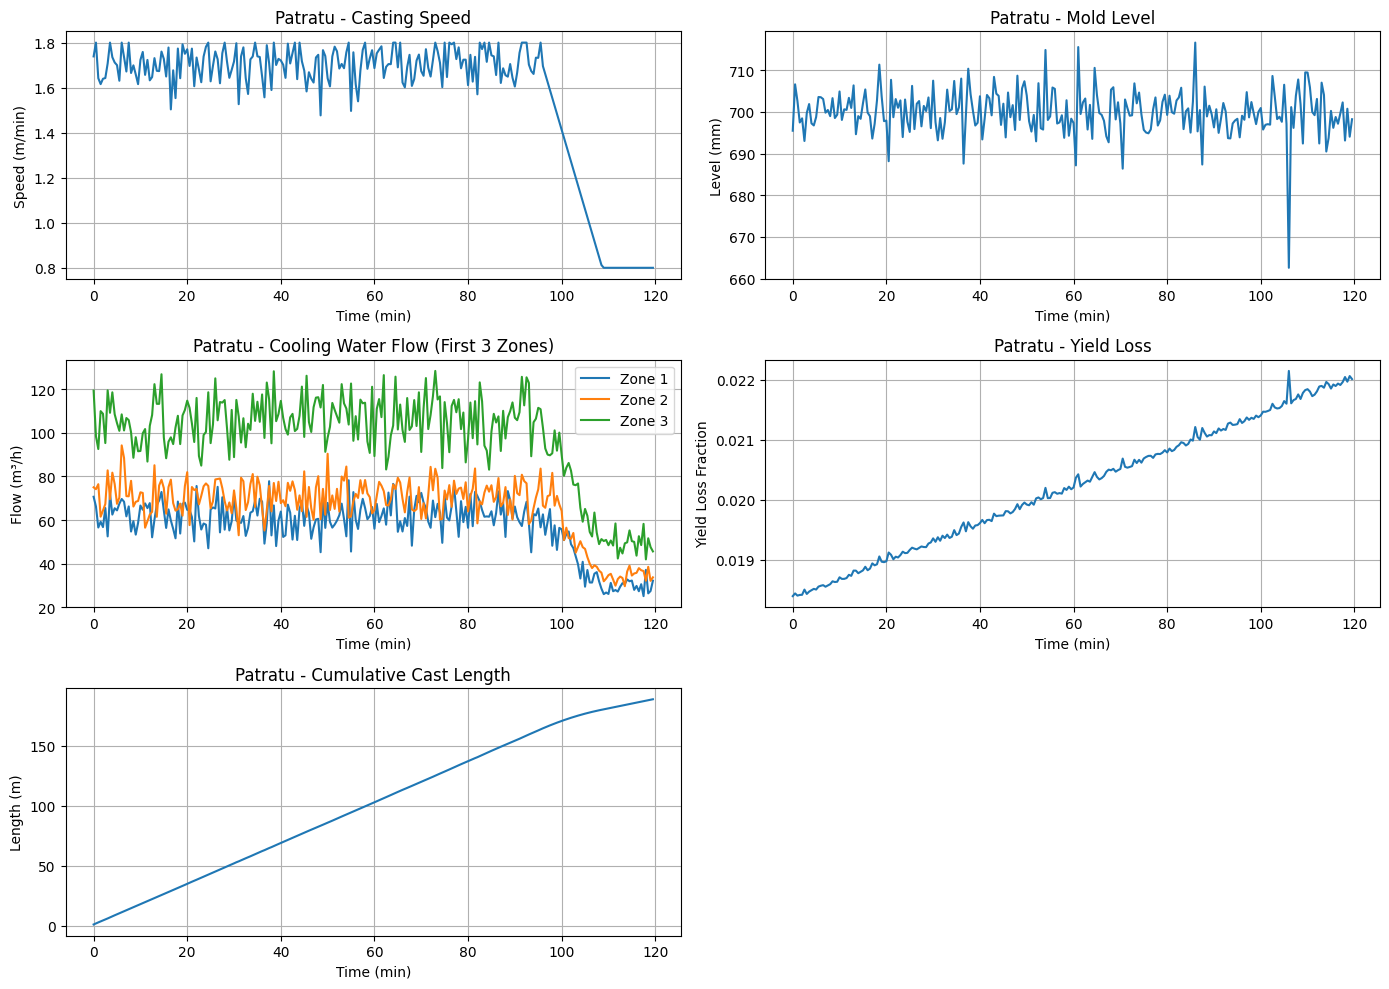

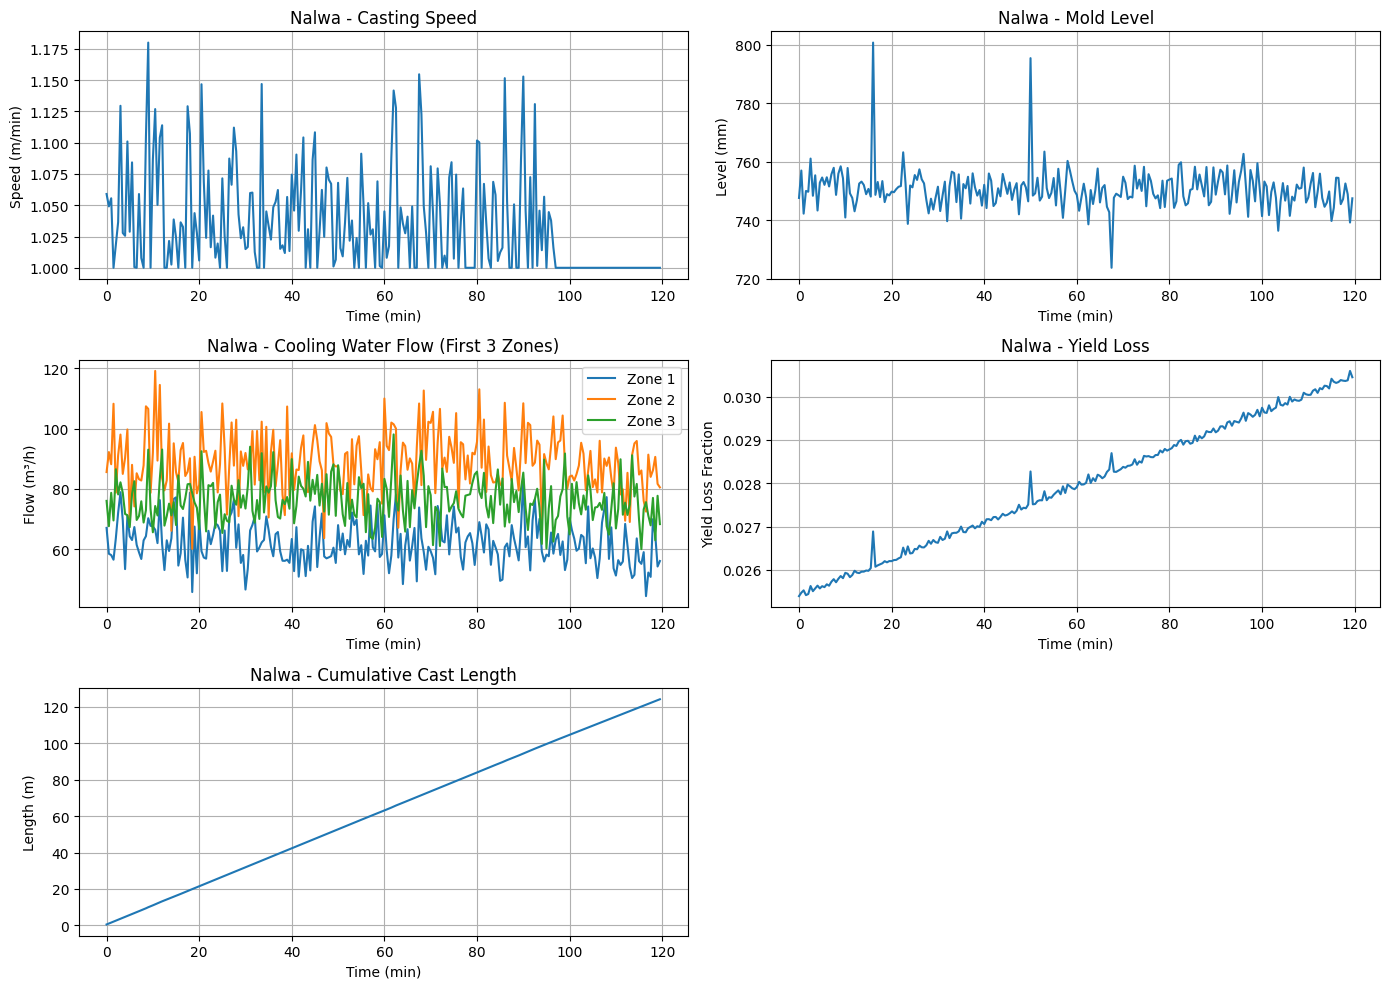

Output saved to patratu_caster_output.csv and nalwa_caster_output.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from random import random, gauss, uniform

class ContinuousCastingSimulation:
    def __init__(self):
        # Caster parameters for Patratu
        self.patratu_params = {
            'max_speed': 1.8,  # m/min
            'min_speed': 0.8,   # m/min
            'mold_level_setpoint': 700,  # mm
            'secondary_cooling_zones': 5,
            'typical_yield_loss': 0.02,  # 2%
            'breakout_prob_base': 0.0005  # base probability per minute
        }

        # Caster parameters for Nalwa
        self.nalwa_params = {
            'max_speed': 2.2,   # m/min
            'min_speed': 1.0,   # m/min
            'mold_level_setpoint': 750,  # mm
            'secondary_cooling_zones': 7,
            'typical_yield_loss': 0.025,  # 2.5%
            'breakout_prob_base': 0.0003  # base probability per minute
        }

        # Common parameters
        self.simulation_time = 120  # minutes
        self.time_step = 0.5  # minutes
        self.cast_length = 10  # meters

    def generate_casting_speed(self, caster_params, time_points):
        """Generate realistic casting speed profile with variability"""
        base_speed = uniform(caster_params['min_speed'], caster_params['max_speed'])

        # Create speed variations
        speeds = []
        for t in time_points:
            # Normal operation with small variations
            if t < 0.8 * self.simulation_time:
                variation = gauss(0, 0.05)
                speed = base_speed * (1 + variation)
            # Speed reduction at end of cast
            else:
                ramp_down = (self.simulation_time - t) / (0.2 * self.simulation_time)
                speed = base_speed * ramp_down

            # Ensure within bounds
            speed = max(caster_params['min_speed'], min(caster_params['max_speed'], speed))
            speeds.append(speed)

        return np.array(speeds)

    def mold_level_control(self, setpoint, time_points):
        """Simulate mold level control with disturbances"""
        levels = []
        disturbance_interval = 15  # minutes
        last_disturbance = -disturbance_interval

        for i, t in enumerate(time_points):
            # Random disturbances
            if t - last_disturbance > disturbance_interval and random() < 0.3:
                disturbance = gauss(0, 30)  # mm
                last_disturbance = t
            else:
                disturbance = 0

            # Normal operation with small variations
            variation = gauss(0, 5)  # mm
            level = setpoint + variation + disturbance * np.exp(-(t - last_disturbance)/2)

            levels.append(level)

        return np.array(levels)

    def secondary_cooling_profile(self, n_zones, time_points, casting_speed):
        """Generate secondary cooling water flow profile"""
        cooling_flows = np.zeros((len(time_points), n_zones))

        # Base flows for each zone (m³/h)
        base_flows = [uniform(50, 100) for _ in range(n_zones)]

        for i, t in enumerate(time_points):
            # Adjust flows based on casting speed
            speed_factor = casting_speed[i] / np.mean(casting_speed)

            # Add some random variation
            variation = [gauss(0, 0.1) for _ in range(n_zones)]

            cooling_flows[i,:] = [f * speed_factor * (1 + v) for f, v in zip(base_flows, variation)]

        return cooling_flows

    def calculate_yield_loss(self, base_loss, time_points, mold_level):
        """Calculate yield loss with variability"""
        # Mold level deviation impact
        level_dev = np.abs(mold_level - np.mean(mold_level)) / np.mean(mold_level)
        level_factor = 1 + 0.5 * level_dev  # Up to 50% additional loss from level variations

        # Random variation
        random_factor = uniform(0.9, 1.1)

        # Time-based trend (slightly increasing loss over time)
        time_factor = 1 + 0.2 * (time_points / self.simulation_time)

        return base_loss * level_factor * random_factor * time_factor

    def simulate_breakouts(self, base_prob, time_points, mold_level, casting_speed):
        """Simulate breakout probability"""
        breakouts = np.zeros(len(time_points), dtype=bool)

        for i, t in enumerate(time_points):
            # Base probability modified by process conditions
            level_dev = np.abs(mold_level[i] - np.mean(mold_level)) / np.mean(mold_level)
            speed_dev = casting_speed[i] / np.mean(casting_speed)

            # Increased probability with level deviations and speed changes
            prob = base_prob * (1 + 2*level_dev) * (1 + 0.5*speed_dev)

            if random() < prob:
                breakouts[i] = True
                # If breakout occurs, stop the simulation
                breakouts[i:] = True
                break

        return breakouts

    def simulate_caster(self, caster_name):
        """Run full simulation for one caster"""
        if caster_name == 'Patratu':
            params = self.patratu_params
        elif caster_name == 'Nalwa':
            params = self.nalwa_params
        else:
            raise ValueError("Unknown caster name")

        # Time points for simulation
        time_points = np.arange(0, self.simulation_time, self.time_step)

        # Generate process parameters
        casting_speed = self.generate_casting_speed(params, time_points)
        mold_level = self.mold_level_control(params['mold_level_setpoint'], time_points)
        cooling_flows = self.secondary_cooling_profile(params['secondary_cooling_zones'],
                                                     time_points, casting_speed)
        yield_loss = self.calculate_yield_loss(params['typical_yield_loss'],
                                              time_points, mold_level)
        breakouts = self.simulate_breakouts(params['breakout_prob_base'],
                                          time_points, mold_level, casting_speed)

        # Calculate cumulative length cast
        cast_length = np.cumsum(casting_speed) * self.time_step

        # Create output dataframe
        data = {
            'Time': time_points,
            'Casting_Speed': casting_speed,
            'Mold_Level': mold_level,
            'Yield_Loss': yield_loss,
            'Breakout': breakouts,
            'Cast_Length': cast_length
        }

        # Add cooling zone flows
        for i in range(params['secondary_cooling_zones']):
            data[f'Cooling_Zone_{i+1}'] = cooling_flows[:,i]

        df = pd.DataFrame(data)
        return df

    def plot_results(self, df, caster_name):
        """Plot simulation results"""
        plt.figure(figsize=(14, 10))

        # Casting Speed
        plt.subplot(3, 2, 1)
        plt.plot(df['Time'], df['Casting_Speed'])
        plt.title(f'{caster_name} - Casting Speed')
        plt.xlabel('Time (min)')
        plt.ylabel('Speed (m/min)')
        plt.grid(True)

        # Mold Level
        plt.subplot(3, 2, 2)
        plt.plot(df['Time'], df['Mold_Level'])
        plt.title(f'{caster_name} - Mold Level')
        plt.xlabel('Time (min)')
        plt.ylabel('Level (mm)')
        plt.grid(True)

        # Cooling Zones (first 3 zones)
        plt.subplot(3, 2, 3)
        for i in range(min(3, len([col for col in df.columns if 'Cooling_Zone' in col]))):
            plt.plot(df['Time'], df[f'Cooling_Zone_{i+1}'], label=f'Zone {i+1}')
        plt.title(f'{caster_name} - Cooling Water Flow (First 3 Zones)')
        plt.xlabel('Time (min)')
        plt.ylabel('Flow (m³/h)')
        plt.legend()
        plt.grid(True)

        # Yield Loss
        plt.subplot(3, 2, 4)
        plt.plot(df['Time'], df['Yield_Loss'])
        plt.title(f'{caster_name} - Yield Loss')
        plt.xlabel('Time (min)')
        plt.ylabel('Yield Loss Fraction')
        plt.grid(True)

        # Cast Length
        plt.subplot(3, 2, 5)
        plt.plot(df['Time'], df['Cast_Length'])
        plt.title(f'{caster_name} - Cumulative Cast Length')
        plt.xlabel('Time (min)')
        plt.ylabel('Length (m)')
        plt.grid(True)

        # Breakout indicator
        if df['Breakout'].any():
            breakout_time = df[df['Breakout']]['Time'].iloc[0]
            plt.subplot(3, 2, 6)
            plt.axvline(x=breakout_time, color='red', linestyle='--')
            plt.text(breakout_time, 0.5, 'BREAKOUT', color='red', ha='center')
            plt.title(f'{caster_name} - Breakout Event at {breakout_time:.1f} min')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def run_simulation(self, output_csv=True):
        """Run simulation for both casters and optionally save to CSV"""
        print("Running Continuous Casting Simulation...")

        # Simulate both casters
        patratu_df = self.simulate_caster('Patratu')
        nalwa_df = self.simulate_caster('Nalwa')

        # Plot results
        self.plot_results(patratu_df, 'Patratu')
        self.plot_results(nalwa_df, 'Nalwa')

        # Save to CSV if requested
        if output_csv:
            patratu_df.to_csv('patratu_caster_output.csv', index=False)
            nalwa_df.to_csv('nalwa_caster_output.csv', index=False)
            print("Output saved to patratu_caster_output.csv and nalwa_caster_output.csv")

        return patratu_df, nalwa_df

# Run simulation
sim = ContinuousCastingSimulation()
patratu_data, nalwa_data = sim.run_simulation(output_csv=True)